<h1>Nettoyage des commentaires</h1>

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant de supprimer la ponctuation, les stop-words et la lemmatisation.



In [1]:
#pip install spacy
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importation de packages nécessaires

import pandas as pd
import json
import nltk
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

<h2>Création de la base de données des commentaires</h2>

In [3]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("data.json", 'r') as file:
    data = json.load(file)

In [4]:
movie_name = []
comments = []
notes = []
year= []
budget=[]
recette=[]
duree=[]

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            year.append(dico['1'])
            notes.append(dico['2'])
            budget.append(dico['3'])
            recette.append(dico['4'])
            duree.append(dico['5'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Annee':year,
    'Note imdb': notes,
    'Budget':budget,
    'Box office':recette,
    'duree':duree
})

df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree
13090,Bohemian Rhapsody (2018),"Bryan Singer's ""Bohemian Rhapsody"" just won so...",2018,"7,9",52000000,910809311,2h 14m
9945,Jumanji : Bienvenue dans la jungle (2017),Doubtlessly there are going to be killjoys who...,2017,"6,9",90000000,995339117,1h 59m
4416,Fast & Furious 8 (2017),It was literally the worst movie that I watche...,2017,"6,6",250000000,1236005118,2h 16m
14560,Star Wars : Épisode III - La Revanche des Sith...,"The first two movies were poorly written, poor...",2005,"7,6",113000000,868390560,2h 20m
3508,La reine des neiges (2013),A fun movie and one of the best Disney films i...,2013,"7,4",150000000,1334291571,1h 42m


<h2>Nettoyage des commentaires</h2>

In [5]:
# Téléchargement d'éléments nécessaires à la tokenisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/louis-
[nltk_data]     armandaumont/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
#!python3 -m spacy download en_core_web_sm

In [12]:
# Tokenisation et suppression de la ponctuation

# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens


In [13]:
# On crée une nouvelle colonne avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens
4306,Fast & Furious 8 (2017),This is the eighth entry in the Fast and the F...,2017,"6,6",250000000,1236005118,2h 16m,"[eighth, entry, Fast, Furious, franchise, time..."
10209,"Moi, moche et méchant 2 (2013)",Minions alone can make the audience laugh. Add...,2013,"7,3",76000000,970766005,1h 38m,"[Minions, audience, laugh, Adding, Gru, 3, lit..."
16602,Transformers 2: La Revanche (2009),"I mean some, well most people say its too long...",2009,"6,0",200000000,836303693,2h 29m,"[mean, people, long, dark, knight, titanic, lo..."
15373,Vice-versa (2015),"We all are victim to our emotions, always susc...",2015,"8,1",175000000,858848019,1h 35m,"[victim, emotions, susceptible, tantrum, sobfe..."
8206,"Moi, moche et méchant 3 (2017)",I love animated movies but this is just cancer...,2017,"6,2",80000000,1034800131,1h 29m,"[love, animated, movies, cancer, brother, Gru,..."


Avec Spacy, l'algortihme s'exécute en près de 6 min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux.

Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [14]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
def lemm(tokens):
    # D'abord, on transforme la liste en doc Spacy
    tokens_as_doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    # Lemmatisation du doc 
    lemmatized = [token.lemma_ for token in tokens_as_doc]
    return lemmatized
# Le lemma_ de Spacy ne reconnait pas les tokens et renvoie des listes vides (Pourquoi ?)

lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [20]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)

df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens,Tokens lemmatisés
16742,Spider-Man (2002),Superior superhero film with a perfect pairing...,2002,"7,4",139000000,825025036,2h 1m,"[Superior, superhero, film, perfect, pairing, ...","[Superior, superhero, film, perfect, pairing, ..."
8546,Star Wars: Épisode I - La menace fantôme (1999),The only reason I am writing this review is to...,1999,"6,5",115000000,1027082707,2h 16m,"[reason, writing, review, revile, Jar, Jar, ne...","[reason, writing, review, revile, Jar, Jar, ne..."
7560,Pirates des Caraïbes : Le secret du coffre mau...,"Ah, Pirates of the Caribbean: The Curse of the...",2006,"7,4",225000000,1066179747,2h 31m,"[Ah, Pirates, Caribbean, Curse, Black, Pearl, ...","[Ah, Pirates, Caribbean, Curse, Black, Pearl, ..."
6545,The Dark Knight Rises (2012),Christopher Nolan has done it again with the l...,2012,"8,4",250000000,1085067637,2h 44m,"[Christopher, Nolan, latest, Batman, movie, fo...","[Christopher, Nolan, latest, Batman, movie, fo..."
15592,Venom (2018),Questionable opening scenes of a fiery spacecr...,2018,"6,6",100000000,856085151,1h 52m,"[Questionable, opening, scenes, fiery, spacecr...","[Questionable, opening, scene, fiery, spacecra..."


<h2>Représentation des mots</h2>

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [16]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud


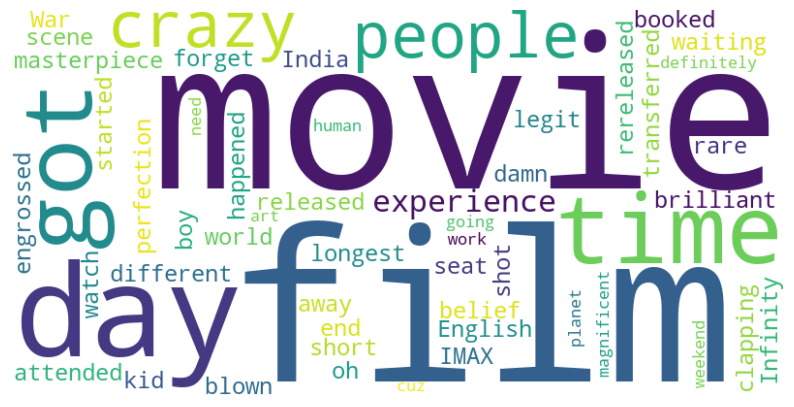

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... .

## Partie ajoutée par Vincent (à revoir)

In [67]:
#!pip install textblob

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /Users/louis-
[nltk_data]     armandaumont/nltk_data...


True

In [52]:
#Convertir les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk et scapy.

On va dans un premier temps utiliser le module TextBlob

In [30]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [31]:
# Appliquez la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [32]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [33]:
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

On essaye enfin de faire de l'analyse de sentiment avec le module scapy.

La fonction ci-dessus ne fonctionne pas bien puisqu'elle retourne que des 0. Je la laisse au cas où trouve le problème.

Les notes sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [50]:
#change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].replace(',', '.')
df['Note imdb']

0        7,9
1        7,9
2        7,9
3        7,9
4        7,9
        ... 
17884    6,1
17885    6,1
17886    6,1
17887    6,1
17888    6,1
Name: Note imdb, Length: 17889, dtype: object

On groupe les observations selon le film.

In [ ]:
grouped = df.groupby('Film')
mean_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb']].mean()
mean_by_group

,sentiment_polarity_nltk,sentiment_polarity_blob,Note imdb
Film,,,
Aladdin,0.594147,0.153070,6.9
Alice au pays des merveilles,0.755444,0.135937,6.4
Aquaman,0.207577,-0.021710,6.8
Avatar,0.857858,0.205706,7.9
Avatar : La Voie de l'eau,0.701461,0.121443,7.6
Avengers,0.763783,0.214765,8.0
Avengers : L'Ère d'Ultron,0.790375,0.150330,7.3
Avengers: Endgame,0.502004,0.181866,8.4
Avengers: Infinity War,0.542414,0.189231,8.4


In [ ]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk est de {correlation}")

La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film est de 0.2978600852174349


In [ ]:
correlation = mean_by_group['sentiment_polarity_blob'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.519272018770084


In [ ]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['sentiment_polarity_blob'])
print(f"La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.7549503705343742


Il y a une relation positive non négligeable entre les notes et le score des commentaires. Il y a également une forte corrélation entre les scores évalués par textblob et ceux évalués par nltk.

# Un peu de Visualisation

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep", color_codes=True)

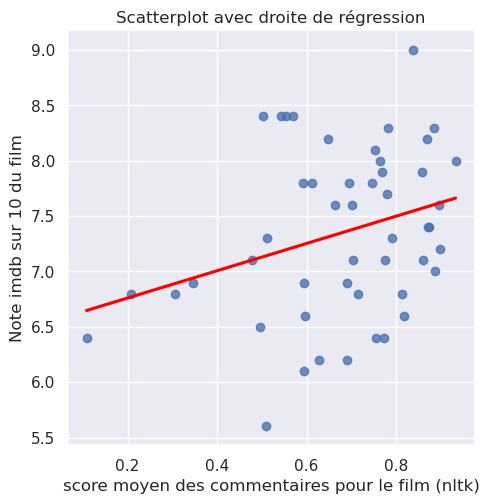

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

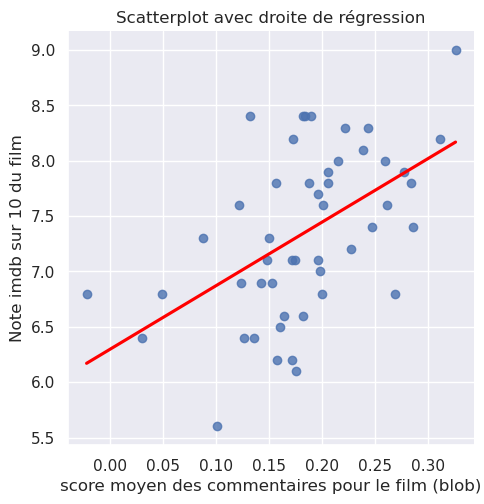

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_blob', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (blob)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

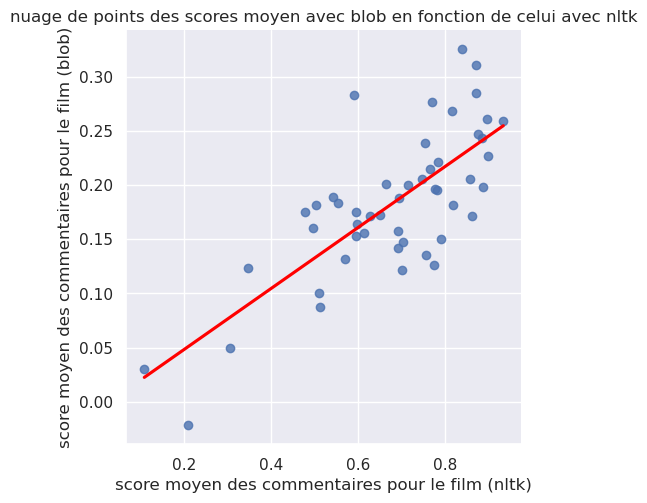

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='sentiment_polarity_blob', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('nuage de points des scores moyen avec blob en fonction de celui avec nltk')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('score moyen des commentaires pour le film (blob)')

# Affichage du graphique
plt.show()